In [4]:
import pandas as pd

clean_df = pd.read_csv("data/clean_data.csv")

In [5]:
with pd.option_context("display.float_format", "{:.1f}".format):
    print(clean_df['price_pln'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]))
    
price_ranges = [
    0,
    3_000,
    5_000,
    10_000,
    20_000,
    50_000,
    80_000,
    100_000,
    150_000,
    200_000,
    300_000,
    400_000,
    500_000,
    3_560_000,
]
df = clean_df.drop(['Unnamed: 0', 'url', 'color', 'posted_date', 'price_net_info', 'location', 'price'], axis=1, errors='ignore')

df["capacity"] = (df["capacity"].str.replace(" cm3", "", regex=False)
                                 .str.replace(" ", "")
                                 .astype(float))

df["power"] = (df["power"].str.replace(" ", "").str.replace("KM", "", regex=False)
                             .astype(float))

df["mileage"] = (df["mileage"].str.replace(" km", "", regex=False)
                               .str.replace(" ", "")
                               .astype(float))

count     25511.0
mean      91894.7
std       93763.1
min        3075.0
10%       22000.0
25%       36777.0
50%       61500.0
75%      125337.0
80%      142557.0
90%      189420.0
95%      242697.5
max     2560000.0
Name: price_pln, dtype: float64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25511 entries, 0 to 25510
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              25510 non-null  object 
 1   model              25510 non-null  object 
 2   seats              24267 non-null  float64
 3   year               25510 non-null  float64
 4   fuel               25510 non-null  object 
 5   capacity           24391 non-null  float64
 6   power              24596 non-null  float64
 7   body_type          25510 non-null  object 
 8   gearbox            25128 non-null  object 
 9   mileage            25476 non-null  float64
 10  condition          25510 non-null  object 
 11  accident_free      18446 non-null  object 
 12  country_of_origin  18335 non-null  object 
 13  title              25511 non-null  object 
 14  price_pln          25511 non-null  float64
 15  equipment          25511 non-null  object 
 16  description        168

In [7]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder

X = df.drop(["price_pln"], axis=1, errors="ignore")
X['equipment'] = X['equipment'].sort_values()
y = pd.cut(df['price_pln'], bins=price_ranges, labels=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cat_feats = ['model', 'condition']
num_feats = ["year", "capacity", "power", "mileage", "seats"]

encoder = TargetEncoder()
prep = ColumnTransformer(
    transformers=[
        ("cat", encoder, cat_feats),
        ("num", "passthrough", num_feats)
    ]
)

clf=RandomForestClassifier(max_depth=2, random_state=0)
rfecv = RFECV(
    estimator=clf,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1
)

pipe = Pipeline([
    ("prep", prep),
    ("rfecv", rfecv)
])

pipe.fit(X_train, y_train)
# df.iloc[180]

Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


,steps,"[('prep', ...), ('rfecv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


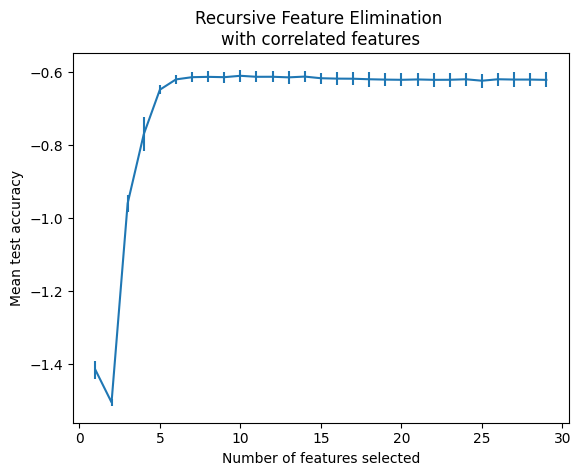

In [10]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

accuracy: 0.45479487849490463

report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.37      0.55      0.44       129
           3       0.28      0.66      0.39       527
           4       0.57      0.59      0.58      2455
           5       0.48      0.34      0.40      1554
           6       0.24      0.31      0.27       566
           7       0.54      0.48      0.51      1057
           8       0.48      0.42      0.45       709
           9       0.43      0.18      0.25       434
          10       0.44      0.20      0.27       123
          11       0.13      0.10      0.12        39
          12       1.00      0.05      0.10        37

    accuracy                           0.45      7654
   macro avg       0.41      0.32      0.31      7654
weighted avg       0.48      0.45      0.45      7654



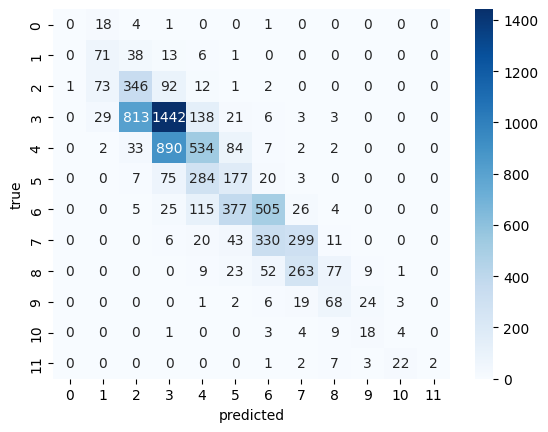

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predictions for entire dataset
y_pred = pipe.predict(X_test).astype(int)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()